In [1]:
from PIL import ImageTk, Image
import numpy as np
from matplotlib import pyplot as plt
import math

# Loading an Image

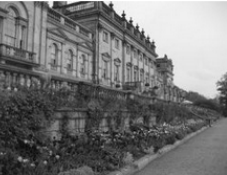

In [2]:
image = Image.open("test2.PNG").convert('RGB')
image

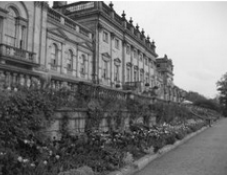

In [3]:
image_grayscale = image.convert('L')
image_grayscale

In [4]:
number_of_levels = 3
image_grayscale_bin = np.array(image_grayscale)
image_grayscale_bin

array([[255, 255, 255, ..., 255, 255, 255],
       [149, 155, 160, ..., 220, 220, 219],
       [132, 136, 139, ..., 212, 212, 211],
       ...,
       [ 60,  54,  32, ..., 104, 101, 101],
       [ 70,  68,  39, ..., 101,  99, 100],
       [ 48,  45,  30, ..., 102,  99, 100]], dtype=uint8)

# Showing grayscale histogram

In [5]:
#Returns an array of len 256 where in each element a count resides
def count_intensities(y_x):
    int_values = np.zeros(shape=(256,))
    intensities = y_x[0]
    counts = y_x[1]
    for i in range(intensities.shape[0]):
        int_values[intensities[i]] = counts[i]
    return int_values

intensities = count_intensities(np.unique(image_grayscale_bin,return_counts=True))

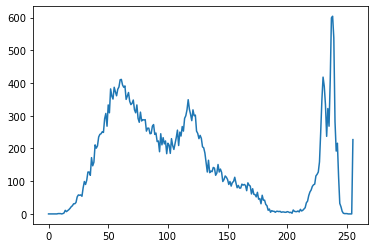

In [6]:
plt.plot(intensities)
#plt.hist(dict(zip(range(0,256),intensities)))

# Мануальное квантование

In [7]:
def transform_to_quanted(image_stock,number_of_levels):
    borders = []
    inter = 256/number_of_levels
    cnt = 1
    while inter*cnt < 255:
        borders.append(round(inter*cnt))
        cnt +=1
    means = [((0+borders[0])/2)]
    for i in range(1,len(borders)-1):
        means.append((borders[i-1] + borders[i])/2)
    means.append(round(borders[-1]+255)/2)
    image = image_stock.copy()
    image[image <= borders[0]] = means[0]
    for i in range(1,len(borders)-1):
        image[(image >= borders[i-1]) & (image < borders[i])] = means[i]
    image[image > borders[-1]] = means[-1]
    return image

In [8]:
number_of_levels = 5

manual_quanted = transform_to_quanted(image_grayscale_bin,number_of_levels)

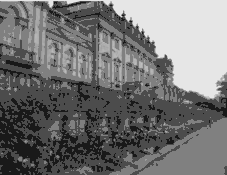

In [9]:
manual_quanted_image = Image.fromarray(manual_quanted)
manual_quanted_image

# Бинаризация методом ОЦУ глобальная

In [10]:
def otsu_global(np_grsc_image):
    histogram = count_intensities(np.unique(np_grsc_image,return_counts=True))
    sum_all_intensities = np.sum(np_grsc_image)
    pixel_count = np_grsc_image.shape[0] * np_grsc_image.shape[1]
    best_tresh = 0
    best_sigma = 0
    first_class_pixel_count = 0
    first_class_intensity_sum = 0
    for i in range(0,256):
        first_class_pixel_count += histogram[i]
        first_class_intensity_sum += i * histogram[i];
        fc_pr = first_class_pixel_count/(pixel_count*1.)
        sc_pr = 1.-fc_pr
        
        fc_mean = first_class_intensity_sum/(max(first_class_pixel_count,1))
        sc_mean = (sum_all_intensities -first_class_intensity_sum) / max((pixel_count-first_class_pixel_count)*1.,1)
        
        mean_dlt = fc_mean - sc_mean
        sigma = fc_pr * sc_pr * mean_dlt * mean_dlt
        #print(sigma)
        if (sigma > best_sigma):
            best_sigma = sigma
            best_thresh = i
    print(best_thresh)
    image_new = np_grsc_image.copy()
    image_new[np_grsc_image >= best_thresh] = 255
    image_new[np_grsc_image < best_thresh] = 0
    return image_new

149


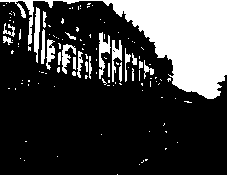

In [11]:
image_otsued_global = Image.fromarray(otsu_global(image_grayscale_bin))
image_otsued_global

# Бинаризация методом ОЦУ локальная

In [12]:
def otsu_local_master(np_grsc_image,tuple_borders):
    image_new = np_grsc_image.copy()
    histogram = count_intensities(np.unique(image_new,return_counts=True))
    for i in tuple_borders:
        otsu_local(image_new,np_grsc_image,histogram,i[0],i[1])
    return image_new
    

def otsu_local(image,image_stock,histogram,border_min,border_max):
    sum_all_intensities = 0
    pixel_count = 0
    for i in range(border_min,border_max):
        sum_all_intensities += histogram[i] * i
        pixel_count += histogram[i]
    best_tresh = 0
    best_sigma = 0
    first_class_pixel_count = 0
    first_class_intensity_sum = 0
    for i in range(border_min,border_max):
        first_class_pixel_count += histogram[i]
        first_class_intensity_sum += i * histogram[i];
        fc_pr = first_class_pixel_count/(pixel_count*1.)
        sc_pr = 1.-fc_pr
        
        fc_mean = first_class_intensity_sum/(max(first_class_pixel_count,1))
        sc_mean = (sum_all_intensities -first_class_intensity_sum) / max((pixel_count-first_class_pixel_count)*1.,1)
        
        mean_dlt = fc_mean - sc_mean
        sigma = fc_pr * sc_pr * mean_dlt * mean_dlt
        #print(sigma)
        if (sigma > best_sigma):
            best_sigma = sigma
            best_thresh = i
    print(best_thresh)
    image[(border_min <= image_stock) & (image >= best_thresh) & (border_max > image_stock)] = 255
    image[(border_min <= image_stock) & (image < best_thresh) & (border_max > image_stock)] = 0

65
137
232


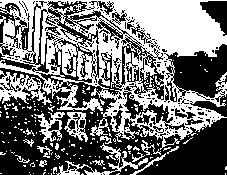

In [13]:
borders = [(0,100),(100,200),(200,256)]
image_otsued_local = Image.fromarray(otsu_local_master(image_grayscale_bin,borders))
image_otsued_local    

# Бинаризация ОЦУ иерархическая

In [25]:
def otsu_hierarchical_master(np_grsc_image):
    image_new = np_grsc_image.copy()
    histogram = count_intensities(np.unique(image_new,return_counts=True))
    borders = [(0,128),(128,256)]
    for a1 in range(2):
        borders_tmp = []
        for a2 in borders:
            ttr= otsu_hierarchical(image_new,histogram,a2[0],a2[1])
            print(ttr)
            borders_tmp.append(ttr)
        borders_new = [(0,borders_tmp[0])]
        for a3 in range(1,len(borders_tmp)):
            borders_new.append((borders_tmp[a3-1],borders_tmp[a3]))
        borders_new.append((borders_tmp[-1],256))
        borders = borders_new
    return borders

def otsu_hierarchical(image,histogram,border_min,border_max):
    sum_all_intensities = 0
    pixel_count = 0
    for i in range(border_min,border_max):
        sum_all_intensities += histogram[i] * i
        pixel_count += histogram[i]
    best_tresh = 0
    best_sigma = 0
    first_class_pixel_count = 0
    first_class_intensity_sum = 0
    for i in range(border_min,border_max):
        first_class_pixel_count += histogram[i]
        first_class_intensity_sum += i * histogram[i];
        fc_pr = first_class_pixel_count/(pixel_count*1.)
        sc_pr = 1.-fc_pr
        
        fc_mean = first_class_intensity_sum/(max(first_class_pixel_count,1))
        sc_mean = (sum_all_intensities -first_class_intensity_sum) / max((pixel_count-first_class_pixel_count)*1.,1)
        
        mean_dlt = fc_mean - sc_mean
        sigma = fc_pr * sc_pr * mean_dlt * mean_dlt
        if (sigma > best_sigma):
            best_sigma = sigma
            best_thresh = i
    return best_thresh


In [31]:
def requant(image_stock,borders):
    image_new = image_stock.copy()
    clrs = []
    for i in borders:
        clrs.append(int(round((i[0]+i[1])/2)))
    for i,j in zip(borders,clrs):
        image_new[(i[0] <= image_stock) & (image_stock > i[1])]  = j
    return image_new

In [32]:
image_grayscale_bin = np.array(image_grayscale)
bdrs = otsu_hierarchical_master(image_grayscale_bin)
otsu_hierarchiced_imaged = Image.fromarray(requant(image_grayscale_bin,bdrs))
otsu_hierarchiced_imaged